In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df_train = pd.read_csv("Dataset/training_balanced.csv")
df_test = pd.read_csv("Dataset/testing.csv")

x_train = df_train.drop(['GradeClass', 'StudentID', 'GPA'], axis=1)
y_train = df_train['GradeClass']
x_test = df_test.drop(['GradeClass', 'StudentID', 'GPA'], axis=1)
y_test = df_test['GradeClass']


categorical_columns = ['Ethnicity', 'Gender']  # Aggiungi altre se necessario

# Concatenazione temporanea dei dataset per garantire coerenza nelle colonne generate
x_combined = pd.concat([x_train, x_test], axis=0)

# Applicazione del One-Hot Encoding
x_combined_encoded = pd.get_dummies(x_combined, columns=categorical_columns, prefix=categorical_columns)

# Separazione dei dataset di training e testing trasformati
x_train = x_combined_encoded.iloc[:x_train.shape[0], :].reset_index(drop=True)
x_test = x_combined_encoded.iloc[x_train.shape[0]:, :].reset_index(drop=True)

numeric_columns = ['StudyTimeWeekly', 'Absences']

# Inizializza lo scaler per la standardizzazione (media = 0, deviazione standard = 1)
scaler = StandardScaler()

# Esegui il fitting solo sulle colonne numeriche del training set
scaler.fit(x_train[numeric_columns])

# Trasforma i dati di training e testing solo sulle colonne numeriche
x_train_scaled_numeric = scaler.transform(x_train[numeric_columns])
x_test_scaled_numeric = scaler.transform(x_test[numeric_columns])

# Aggiorna i DataFrame originali con i dati scalati
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

x_train_scaled[numeric_columns] = x_train_scaled_numeric
x_test_scaled[numeric_columns] = x_test_scaled_numeric

# Mostra il DataFrame scalato
print(len(x_train_scaled))





In [ ]:
plt.figure(figsize=(8, 6))
x_combined = pd.concat([x_test_scaled, y_test], axis=1)
print(len(x_combined))
ax = sns.countplot(data=x_combined, x='GradeClass', palette="Oranges")

#df_train_resampled.to_csv("Dataset/dataset_resampled.csv", index=False)

# Annotazioni sui valori
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.title('Distribuzione di GradeClass')
plt.xlabel('GradeClass')
plt.ylabel('Conteggio')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
x_combined = pd.concat([x_train_scaled, y_train], axis=1)
print(len(x_combined))
ax = sns.countplot(data=x_combined, x='GradeClass', palette="Oranges")

#df_train_resampled.to_csv("Dataset/dataset_resampled.csv", index=False)

# Annotazioni sui valori
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.title('Distribuzione di GradeClass')
plt.xlabel('GradeClass')
plt.ylabel('Conteggio')
plt.show()


## Classificazione

In [ ]:
models_def_params = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

In [ ]:
for model_name, model in models_def_params.items():
    print(model_name, model)
    model.fit(x_train_scaled, y_train)  # Addestrare il modello
    y_pred = model.predict(x_test_scaled)  # Predizione sui dati di test
    print(f"\n{model_name} - Test Set Evaluation")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

## Grid search

In [ ]:
# Definisci la griglia di parametri per Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search su Random Forest
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train_scaled, y_train)


# Miglior modello trovato
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)


In [ ]:
# Definire la griglia di parametri per AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200],  # Numero di stadi (alberi)
    'learning_rate': [0.01, 0.1, 1.0],  # Tasso di apprendimento
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]  # Alberi base
}

# Creare un'istanza di AdaBoost
ada_boost = AdaBoostClassifier()

# Configurare GridSearchCV
grid_search = GridSearchCV(estimator=ada_boost, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Eseguire la Grid Search
grid_search.fit(x_train_scaled, y_train)

# Visualizzare i migliori parametri e il miglior score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

In [ ]:
# Definire la griglia di parametri per KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Numero di vicini
    'weights': ['uniform', 'distance'],  # Criterio di pesatura
    'metric': ['minkowski', 'euclidean', 'manhattan'],  # Metriche di distanza
    'p': [1, 2],  # Parametro di distanza per Minkowski (1=Manhattan, 2=Euclidean)
}

# Creare un'istanza del modello KNN
knn = KNeighborsClassifier()

# Configurare GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Eseguire la Grid Search
grid_search.fit(x_train_scaled, y_train)

# Visualizzare i migliori parametri e il miglior score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)


In [ ]:
# Definire la griglia di parametri per GaussianNB
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],  # Variabile di smoothing per evitare problemi numerici
}

# Creare un'istanza del modello GaussianNB
gnb = GaussianNB()

# Configurare GridSearchCV
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Eseguire la Grid Search
grid_search.fit(x_train_scaled, y_train)

# Visualizzare i migliori parametri e il miglior score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

## Classificazione aggiornata

In [ ]:
models_pers_params = {
    "Random Forest": RandomForestClassifier(max_depth= 30, n_estimators=200),
    "K-Nearest Neighbors": KNeighborsClassifier(metric = 'minkowski', n_neighbors=11, p=1, weights = 'distance' ),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(var_smoothing= 1e-09),
    "AdaBoost Classifier": AdaBoostClassifier(n_estimators=50, estimator= DecisionTreeClassifier(max_depth=3)),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42)
}

In [ ]:
for model_name, model in models_pers_params.items():
    print(model_name, model)
    model.fit(x_train_scaled, y_train)  # Addestrare il modello
    y_pred = model.predict(x_test_scaled)  # Predizione sui dati di test
    print(f"\n{model_name} - Test Set Evaluation")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

## Ensamble learning

/Users/lauraferretti/.venvs/textToSpeech/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        33
         1.0       0.33      0.03      0.05        80
         2.0       0.00      0.00      0.00       121
         3.0       0.08      0.01      0.01       127
         4.0       0.51      0.99      0.68       357

    accuracy                           0.50       718
   macro avg       0.18      0.20      0.15       718
weighted avg       0.31      0.50      0.34       718



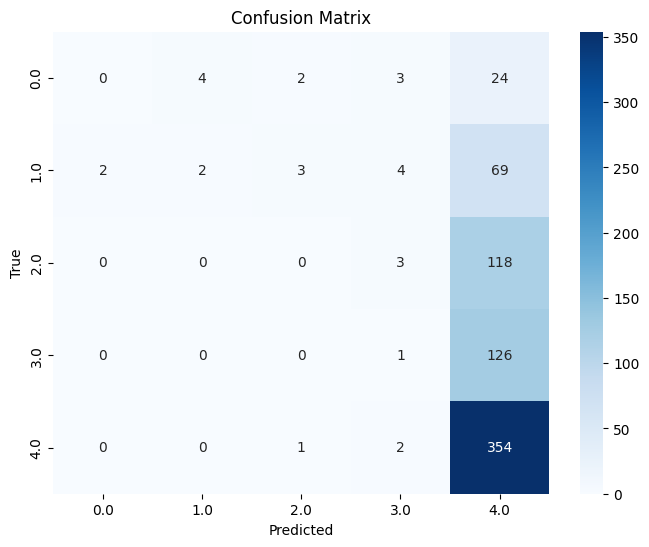

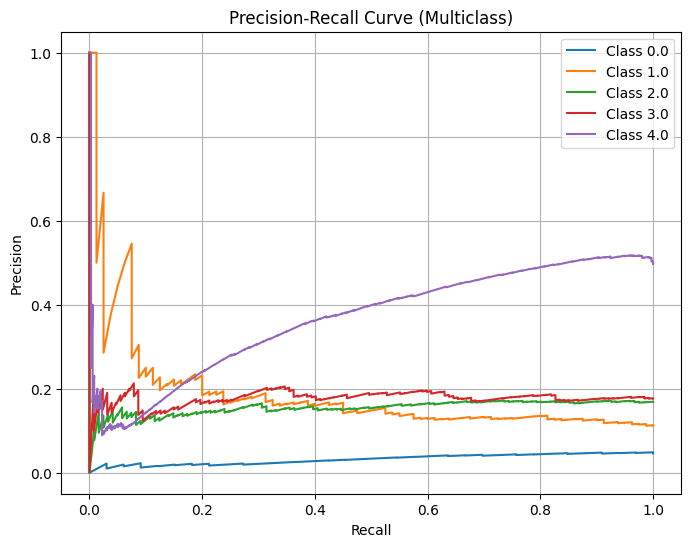

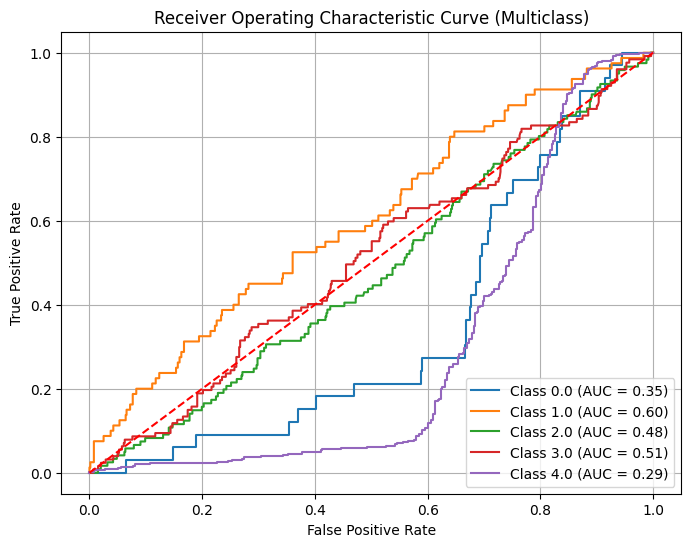

/Users/lauraferretti/.venvs/textToSpeech/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/lauraferretti/.venvs/textToSpeech/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/lauraferretti/.venvs/textToSpeech/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/lauraferretti/.venvs/textToSpeech/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

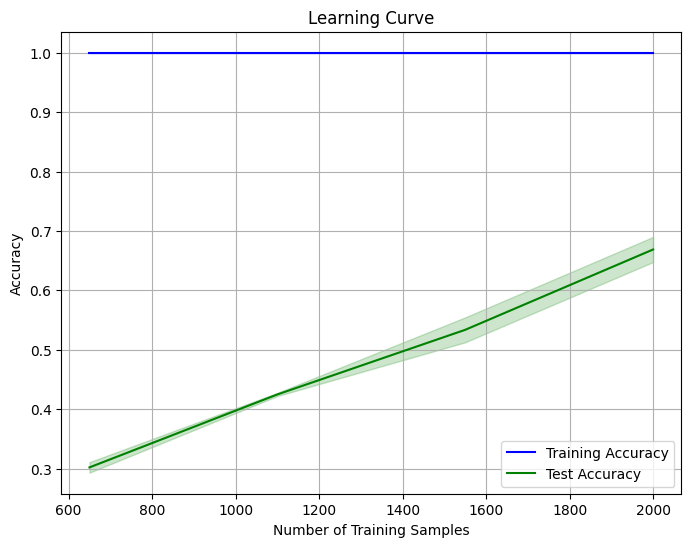

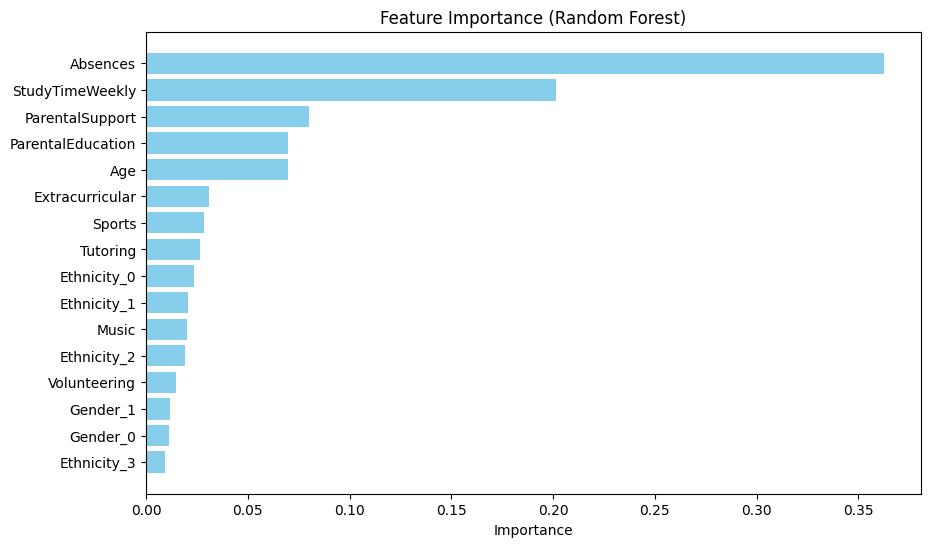

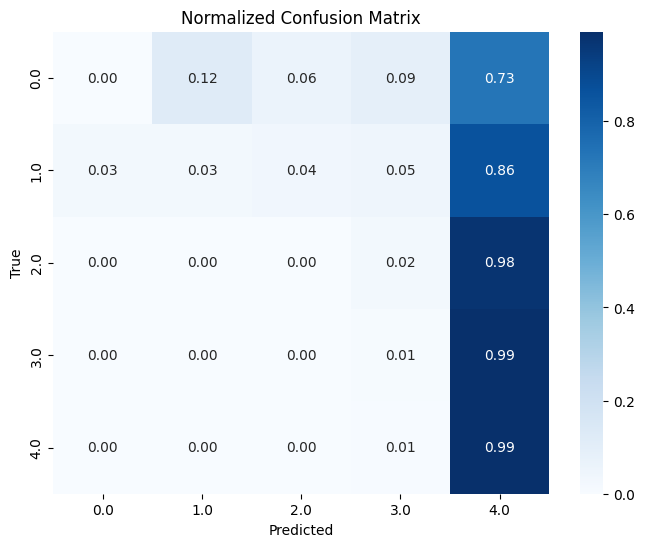

In [10]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Definire il Voting Classifier con soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth= 30, n_estimators=200)),
        ('knn', KNeighborsClassifier(metric='minkowski', n_neighbors=3, p=1, weights='distance')),
        ('dt', DecisionTreeClassifier()),
        ('nb', GaussianNB(var_smoothing=1e-07)),
        ('ada', AdaBoostClassifier(n_estimators=50, estimator= DecisionTreeClassifier(max_depth=3))),
        ('gbc', GradientBoostingClassifier(random_state=42))

    ],
    voting='soft',  # Usando soft voting
    n_jobs=-1  # Usa tutti i core disponibili
)

# Addestrare il Voting Classifier
voting_clf.fit(x_train_scaled, y_train)

# Predire e calcolare l'accuratezza
y_pred = voting_clf.predict(x_test)

# Calcolare e visualizzare il classification report
print(classification_report(y_test, y_pred))

# **Confusion Matrix**
cm = confusion_matrix(y_test, y_pred)

# Visualizzare la matrice di confusione come una heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Curva Precision-Recall per Multiclass**
y_test_bin = label_binarize(y_test, classes=voting_clf.classes_)

plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    y_scores = voting_clf.predict_proba(x_test)[:, i]  # Probabilità per ogni classe
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores)
    plt.plot(recall, precision, label=f'Class {voting_clf.classes_[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Multiclass)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# **Curva ROC per Multiclass**
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], voting_clf.predict_proba(x_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {voting_clf.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linea casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (Multiclass)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **Learning Curve**
train_sizes, train_scores, test_scores = learning_curve(voting_clf, x_train_scaled, y_train, cv=5)

# Calcolare la media e la deviazione standard dei punteggi
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Tracciare la learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, test_mean, label='Test Accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# **Feature Importance (Random Forest)**
importances = voting_clf.named_estimators_['rf'].feature_importances_

# Creare un dataframe per le feature importances
features = x_train_scaled.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Ordinare per importanza
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Tracciare un bar plot per le feature più importanti
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invertire l'asse y per mostrare le feature più importanti in alto
plt.show()

# **Matrice di Confusione Normalizzata**
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualizzare la matrice di confusione normalizzata
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


### alternativa con logistic regression

/Users/lauraferretti/.venvs/textToSpeech/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/lauraferretti/.venvs/textToSpeech/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/lauraferretti/.venvs/textToSpeech/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/lauraferretti/.venvs/textToSpeech/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        33
         1.0       0.25      0.01      0.02        80
         2.0       0.12      0.02      0.03       121
         3.0       0.20      0.01      0.02       127
         4.0       0.51      0.99      0.68       357

    accuracy                           0.50       718
   macro avg       0.22      0.21      0.15       718
weighted avg       0.34      0.50      0.35       718



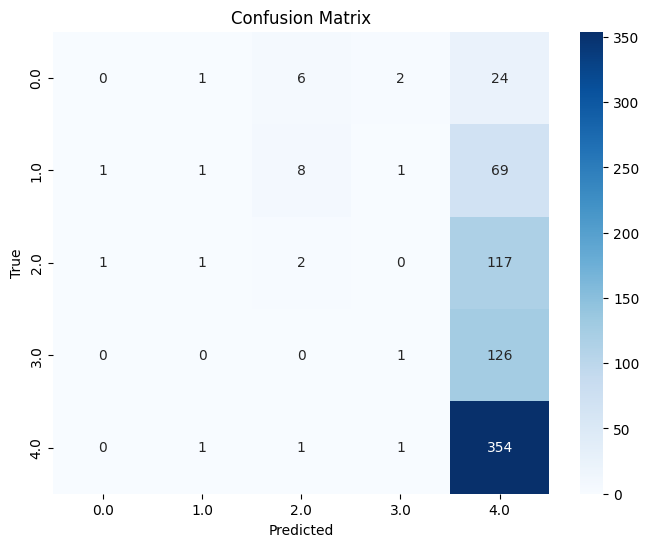

In [11]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Definire i modelli di base
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42)),
    ('knn', KNeighborsClassifier(metric='minkowski', n_neighbors=3, p=1, weights='distance')),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('nb', GaussianNB()),
    ('ada', AdaBoostClassifier(n_estimators=200, estimator=DecisionTreeClassifier(max_depth=3), random_state=42)),
    ('gbc', GradientBoostingClassifier(random_state=42))
]

# Meta-modello
meta_model = LogisticRegression()

# Creare il modello di stacking
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    n_jobs=-1
)

# Addestrare il modello di stacking
stacking_clf.fit(x_train_scaled, y_train)

# Predire e calcolare l'accuratezza
y_pred = stacking_clf.predict(x_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Visualizzare la matrice di confusione come una heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=stacking_clf.classes_, yticklabels=stacking_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
